**Data Exploration**

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import os
from PIL import Image

In [10]:
# Get labels of images
train_df = pd.read_csv(f"/kaggle/input/train-csv/trainLabels.csv")
print(f'No.of.training_samples: {len(train_df)}')

No.of.training_samples: 89634


In [7]:
train_df.head()

,image,level
0,10_left,0.0
1,10_right,0.0
2,13_left,0.0
3,13_right,0.0
4,15_left,1.0


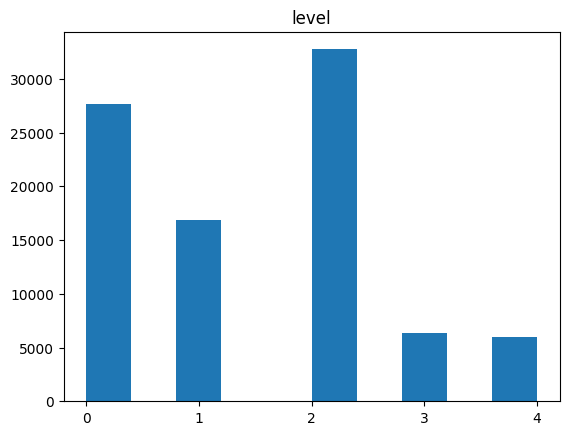

In [11]:
# Histogram of label counts
train_df.hist()
plt.xticks([0,1,2,3,4])
plt.grid(False)
plt.show()

**Data Visualization**

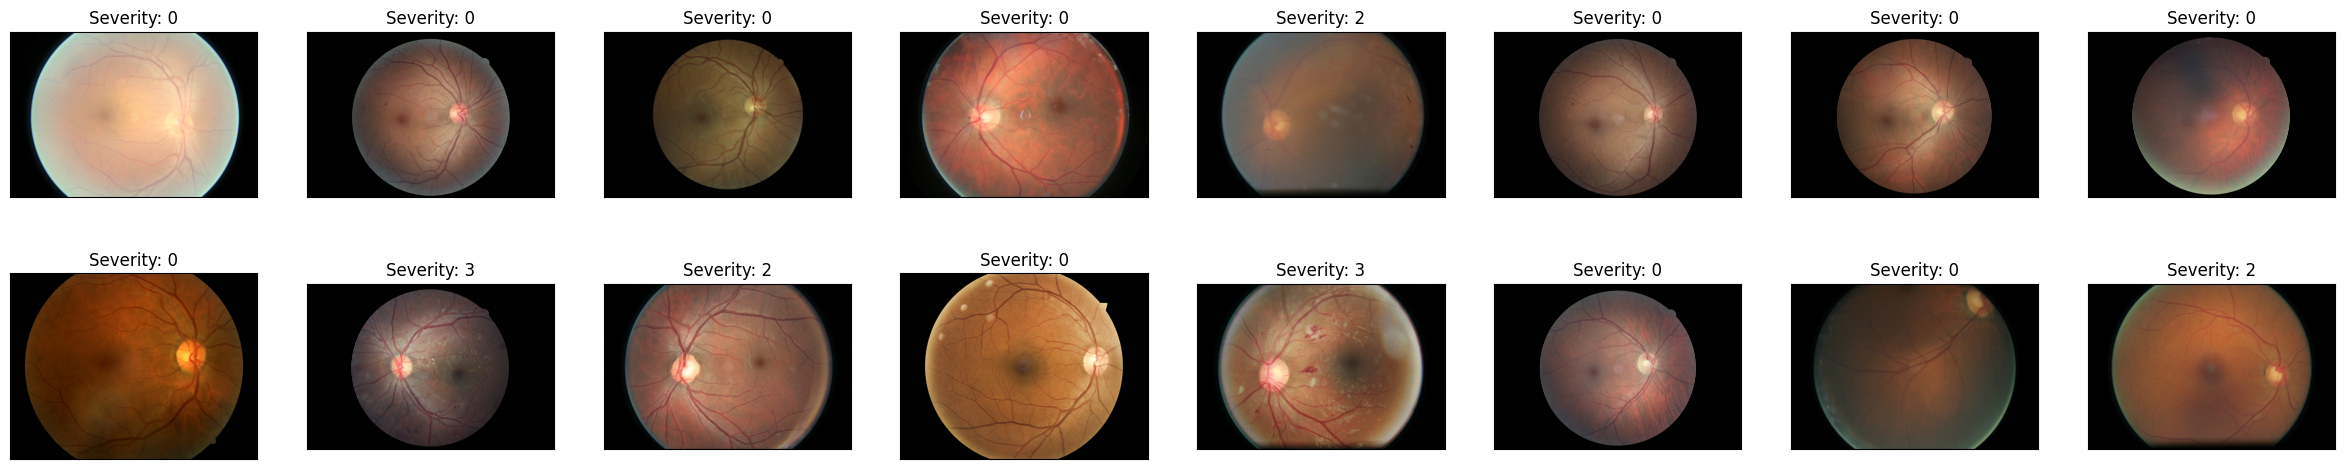

In [ ]:
# Display images
fig = plt.figure(figsize=(30, 6))
# display 16 images
train_imgs = os.listdir('/kaggle/input/dr-train/train')
for idx, img in enumerate(np.random.choice(train_imgs, 16)):
    ax = fig.add_subplot(2, 16//2, idx+1, xticks=[], yticks=[])
    im = Image.open('/kaggle/input/dr-train/train/' + img)
    plt.imshow(im)
    lab = train_df.loc[train_df['image'] == img.split('.')[0], 'level'].values[0]
    ax.set_title('Severity: %s'%lab)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # Use GPU if it's available or else use CPU.
print(device) # Print the device

cuda


**Data Augmentation**

In [ ]:
# Image augmentation with rotation
def rotate_image(image_path, angle, save_path):
    img = Image.open(image_path)
    rotated_img = img.rotate(angle, expand=True)
    rotated_img.save(save_path, 'JPEG')
    return save_path.split('/')[-1]  # Return the filename

def mirror_image(image_path, save_path):
    img = Image.open(image_path)
    img_np = np.array(img)  # Convert PIL image to NumPy array
    mirrored_img_np = cv2.flip(img_np, 1)  # Mirror the image
    mirrored_img = Image.fromarray(mirrored_img_np)  # Convert back to PIL image
    mirrored_img.save(save_path, 'JPEG')
    return save_path.split('/')[-1]  # Return the filename

def augment_images_with_rotation(csv_path, dataset_path, augmented_path, angle):
    train_df = pd.read_csv(csv_path)
    augmented_rows = []

    # Filter images belonging to the target class
    target_images = train_df[train_df['level'] != 0]['image']

    for img_name in target_images:
        img_name = img_name + '.jpeg'
        src_path = os.path.join(dataset_path, img_name)

        if os.path.exists(src_path):
            # Rotate the image
            aug_img_name = img_name.replace('.jpeg', f'_rotated_{angle}.jpeg')
            save_path = os.path.join(augmented_path, aug_img_name)
            rotated_filename = rotate_image(src_path, angle, save_path)
            # Append new rows into csv file
            augmented_rows.append({'image': rotated_filename.replace('.jpeg', ''),
                                        'level': train_df.loc[train_df['image'] == img_name.replace('.jpeg', ''), 'level'].values[0]
                                        })
    # Convert augmented_rows list to DataFrame
    new_rows_df = pd.DataFrame(augmented_rows)
    return new_rows_df

def augment_images_with_mirror(csv_path, dataset_path, augmented_path):
    train_df = pd.read_csv(csv_path)
    augmented_rows = []

    # Filter images belonging to the target class
    target_images = train_df[train_df['level'] != 0]['image']

    for img_name in target_images:
        img_name = img_name + '.jpeg'
        src_path = os.path.join(dataset_path, img_name)

        if os.path.exists(src_path):
            # Mirror the image
            mirror_img_name = img_name.replace('.jpeg', f'_mirror.jpeg')
            save_path = os.path.join(augmented_path, mirror_img_name)
            mirrored_filename = mirror_image(src_path, save_path)
            augmented_rows.append({'image': mirrored_filename.replace('.jpeg', ''),
                                        'level': train_df.loc[train_df['image'] == img_name.replace('.jpeg', ''), 'level'].values[0]
                                        })

    # Convert augmented_rows list to DataFrame
    new_rows_df = pd.DataFrame(augmented_rows)
    return new_rows_df

In [ ]:
# Rotate images
from PIL import Image
import os

csv_path = '/kaggle/input/train-csv/trainLabels.csv'
dataset_path = '/kaggle/input/dr-train/train'
augmented_path = '/kaggle/working/'

df1 = augment_images_with_rotation(csv_path, dataset_path, dataset_path, 90)
df2 = augment_images_with_rotation(csv_path, dataset_path, dataset_path, 120)
df3 = augment_images_with_rotation(csv_path, dataset_path, dataset_path, 180)
df4 = augment_images_with_rotation(csv_path, dataset_path, dataset_path, 270)
df5 = augment_images_with_mirror(csv_path, dataset_path, dataset_path)

In [ ]:
# Append all new rows DataFrames to the original DataFrame
augmented_df = pd.concat([train_df, df1, df2, df3, df4, df5], ignore_index=True)

# Save the updated DataFrame to CSV
output_csv_path = './trainLabels_augmented.csv'
augmented_df.to_csv(output_csv_path, index=False, header=True)

**Image Processing**

In [ ]:
def denoise_and_CLAHE(image_path, save_path):
    # Load the image
    img = cv2.imread(image_path)

    # Denoise image
    denoised_img = cv2.fastNlMeansDenoisingColored(img, None, 10, 10, 7, 21)

    # CLAHE
    img_yuv = cv2.cvtColor(denoised_img, cv2.COLOR_BGR2YUV)
    clahe = cv2.createCLAHE(clipLimit = 2.0, tileGridSize = (8, 8))
    img_yuv[:,:,0] = clahe.apply(img_yuv[:,:,0])
    img_clahe = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)

    # Save image
    cv2.imwrite(save_path, img_clahe)

def image_processing(csv_path, input_folder, output_folder):
    # Read the CSV file
    df = pd.read_csv(csv_path)

    # Process each image listed in the CSV file
    for img_name in df['image']:
        img_name = img_name + '.jpeg'
        image_path = os.path.join(input_folder, img_name)
        save_path = os.path.join(output_folder, img_name)

        if os.path.exists(image_path):
            denoise_and_CLAHE(image_path, save_path)
            print(f"Image {image_path} processed.")
        else:
            print(f"Image {image_path} does not exist.")

In [ ]:
save_path = '/kaggle/working/'
image_processing(csv_path, dataset_path, save_path)

In [ ]:
from sklearn.utils import class_weight #For calculating weights for each class.
class_weights = class_weight.compute_class_weight(class_weight='balanced',classes=np.array([0,1,2,3,4]),y=train_df['level'].values)
class_weights = torch.tensor(class_weights,dtype=torch.float).to(device)

print(class_weights) #Prints the calculated weights for the classes.

tensor([0.6492, 1.0628, 0.5475, 2.8050, 2.9789], device='cuda:0')


In [ ]:
from torch.utils.data import Dataset

class dataset(Dataset): # Inherits from the Dataset class.
    '''
    dataset class overloads the __init__, __len__, __getitem__ methods of the Dataset class.

    Attributes :
        df:  DataFrame object for the csv file.
        data_path: Location of the dataset.
        image_transform: Transformations to apply to the image.
        train: A boolean indicating whether it is a training_set or not.
    '''

    def __init__(self,df,data_path,image_transform=None,train=True): # Constructor.
        super(Dataset,self).__init__() #Calls the constructor of the Dataset class.
        self.df = df
        self.data_path = data_path
        self.image_transform = image_transform
        self.train = train

    def __len__(self):
        return len(self.df) #Returns the number of samples in the dataset.

    def __getitem__(self,index):
        image_id = self.df['image'][index]

        # Check both png and jpeg formats
        image_path_png = os.path.join(self.data_path, f'{image_id}.png')
        image_path_jpeg = os.path.join(self.data_path, f'{image_id}.jpeg')

        if os.path.exists(image_path_png):
            image = Image.open(image_path_png)
        elif os.path.exists(image_path_jpeg):
            image = Image.open(image_path_jpeg)
        else:
            raise FileNotFoundError(f'Image {image_id} not found in .png or .jpeg format.')

        if self.image_transform :
            image = self.image_transform(image) #Applies transformation to the image.

        if self.train :
            label = self.df['level'][index] #Label.
            return image,label #If train == True, return image & label.

        else:
            return image #If train != True, return image.

In [ ]:
from torch.utils.data import DataLoader, random_split
from torchvision import transforms

# Define transforms
transform = transforms.Compose([transforms.Resize([512, 512]),
                                transforms.ToTensor(),
                                transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
# Extract the full dataset
data = dataset(train_df, dataset_path, image_transform=transform)

# Create validation set
validation_split = 0.2
num_train = len(data)
num_val = int(validation_split * num_train)
num_train -= num_val

# Create training and validation set
train_data, val_data = torch.utils.data.random_split(data, [num_train, num_val])

# Create training, validation and test loaders
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64)

In [ ]:
import torchvision.models as models

model = models.resnet34(pretrained=True)

# Replace the final layer with a layer that has the correct number of output classes
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 5)

# If GPU is available, move the model to GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [ ]:
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

**Model Training**

In [ ]:
num_epochs = 30
patience = 3  # Number of epochs to wait for improvement
best_val_loss = float('inf')
patience_counter = 0

# Establish a list of history
train_loss_history = list()
val_loss_history = list()

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs.data, 1)
        train_correct += (preds == labels).float().mean().item()
        train_loss += loss.item()

    print(f'Epoch {epoch + 1} training accuracy: {train_correct/len(train_loader):.2f}% training loss: {train_loss/len(train_loader):.5f}')
    train_loss_history.append(train_loss/len(train_loader))

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_correct = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).float().mean().item()
            val_loss += loss.item()

    print(f'Epoch {epoch + 1} validation accuracy: {val_correct/len(val_loader):.2f}% validation loss: {val_loss/len(val_loader):.5f}')
    val_loss_history.append(val_loss/len(val_loader))

    # Check for early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0  # Reset the counter if validation loss improves
        best_model = model.state_dict()  # Save the best model weights
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f'Early stopping at epoch {epoch + 1}')
            model.load_state_dict(best_model)  # Load the best model weights
            break

print("Training complete.")

In [ ]:
# Plot the training and validation loss history
plt.plot(train_loss_history, label="Training Loss")
plt.plot(val_loss_history, label="Validation Loss")
plt.legend()
plt.show()

In [ ]:
# Load the model and optimizer state dicts
checkpoint = torch.load('/kaggle/input/model3/pytorch/model3/3/checkpoint.pth', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
best_val_loss = checkpoint['best_val_loss']

In [ ]:
print("Model: ", model)
print("Optimizer: ", optimizer)
print("Val loss: ", best_val_loss/len(val_loader))

**Model Deployment**

In [ ]:
import torch
from torchvision import models
from torch.utils.mobile_optimizer import optimize_for_mobile

# Ensure model is in evaluation mode
model.eval()

# Trace the model with an example input
example = torch.rand(1, 3, 512, 512).to(device)
traced_script_module = torch.jit.script(model, example)

# Optimize the traced model for mobile
optimized_traced_model = optimize_for_mobile(traced_script_module)

# Save the optimized traced model for mobile deployment
optimized_traced_model._save_for_lite_interpreter("Model1.pt")

print("Model has been optimized and saved for mobile deployment.")